Installation steps for windows user

1) In Anaconda Prompt: conda install rpy2

2) In Command Prompt: pip install tzlocal

3) Copy tzlocal folder to Anaconda3\Lib\site-packages

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import math
from sklearn.metrics import f1_score,confusion_matrix
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
import rpy2.robjects.packages as rpackages

In [2]:
df = pd.read_csv('binary_classification.csv',index_col='employee_id')

In [3]:
df.head(3)

,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
employee_id,,,,,,,,,,,,,
65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0
65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0
7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0


There are 12 features and 1 binary target variables.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54808 entries, 65438 to 51526
Data columns (total 13 columns):
department              54808 non-null object
region                  54808 non-null object
education               52399 non-null object
gender                  54808 non-null object
recruitment_channel     54808 non-null object
no_of_trainings         54808 non-null int64
age                     54808 non-null int64
previous_year_rating    50684 non-null float64
length_of_service       54808 non-null int64
KPIs_met >80%           54808 non-null int64
awards_won?             54808 non-null int64
avg_training_score      54808 non-null int64
is_promoted             54808 non-null int64
dtypes: float64(1), int64(7), object(5)
memory usage: 5.9+ MB


It can be seen [education] and [previous_year_rating] have missing values. I decided to label the missing values in [education] features as 'No Education Info'. However, I have a hypothesis that the missing values in [previous_year_rating] is because that particular employee's length of service is 1. 

In [5]:
#Check the unique values of [length_of_service] where previous_year_rating is nan
print(df[df.previous_year_rating.isna()].length_of_service.drop_duplicates().values.item())

1


It can be seen that the hypothesis is not rejected. So, we can not simply done the median/mean imputation on [previous_year_rating] feature. 

In [6]:
#Check the unique values of previous_year_rating
print(df.previous_year_rating.drop_duplicates().values)

[ 5.  3.  1.  4. nan  2.]


It can be seen that the [previous_year_rating] elements are integers. So, rather than do the mean/median imputation, I decided to transform this feature into categorical feature and label the missing value as 'no_prev_year_rating'. 

In [7]:
#Rename the columns
df=df.rename(columns={"KPIs_met >80%": "KPIs_met_80","no_of_trainings": "previous_year_no_of_trainings",
                      "awards_won?":"previous_year_awards_won"})
#Imputing missing values and transform
df.education=df.education.fillna('No Education Info')
df.previous_year_rating=df.previous_year_rating.fillna('no_prev_year_rating')
df.previous_year_rating=df.previous_year_rating.replace(1,'1_prev_year_rating')
df.previous_year_rating=df.previous_year_rating.replace(2,'2_prev_year_rating')
df.previous_year_rating=df.previous_year_rating.replace(3,'3_prev_year_rating')
df.previous_year_rating=df.previous_year_rating.replace(4,'4_prev_year_rating')
df.previous_year_rating=df.previous_year_rating.replace(5,'5_prev_year_rating')

In [8]:
df.head(3)

,department,region,education,gender,recruitment_channel,previous_year_no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met_80,previous_year_awards_won,avg_training_score,is_promoted
employee_id,,,,,,,,,,,,,
65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5_prev_year_rating,8,1,0,49,0
65141,Operations,region_22,Bachelor's,m,other,1,30,5_prev_year_rating,4,0,0,60,0
7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3_prev_year_rating,7,0,0,50,0


In [9]:
#Check the proportion of the target variable
print('is_promoted=1 : ',len(df[df.is_promoted==1]))
print('is_promoted=0 : ',len(df[df.is_promoted==0]))

is_promoted=1 :  4668
is_promoted=0 :  50140


It can be seen that the proportion of the target variable is imbalanced, 1:10 ratio. So, we have to be careful when split our dataset into training and test set.

In [10]:
#Train Test Split which keeping the same proportion of the target variable
X=df.drop('is_promoted',1)
y=df[['is_promoted']]
split_0=list(np.random.choice(y[y.is_promoted==0].index.tolist(),math.floor(0.7*len(y[y.is_promoted==0])),replace=False))
split_1=list(np.random.choice(y[y.is_promoted==1].index.tolist(),math.floor(0.7*len(y[y.is_promoted==1])),replace=False))
train_split=split_0+split_1 
test_split=list(set(X.index)-(set(train_split)))
X_Train, X_Test, y_Train, y_Test = X.loc[train_split],X.loc[test_split],y.loc[train_split],y.loc[test_split]

This tutorial is focusing on using RPy2 as the bridge between Python and R to do the classification using gbm. So, we just jump to the modeling process without any feature engineering 

In [11]:
#Input your desired R packages
R_packages=['gbm','randomForest','varImp']

#Install the desired R packages
utils=rpackages.importr('utils')
utils.chooseCRANmirror(ind=1)
for package in R_packages:
    if not(rpackages.isinstalled(package)):
        utils.install_packages(package)

Please stay alert on the pop-up windows and approve the installation request.

In [12]:
#Importing the desired R packages
gbm=rpackages.importr('gbm')

In [13]:
#As a 'bridge' between python and R environment
r=robjects.r

In [14]:
#Preparing data for the input to R global environment
df_Train=X_Train
df_Train['is_promoted']=y_Train
df_Test=X_Test
df_Test['is_promoted']=y_Test

#Input data to R global environment
robjects.globalenv['r_df_Train']=pandas2ri.py2ri(df_Train)
robjects.globalenv['r_df_Test']=pandas2ri.py2ri(df_Test)
#Running in R environment
r('''
factor_cols<-c("department","region","education","gender","recruitment_channel","previous_year_rating","KPIs_met_80","previous_year_awards_won")
numeric_cols<-c("previous_year_no_of_trainings","length_of_service","age","avg_training_score","is_promoted")
r_df_Train[factor_cols] <- lapply(r_df_Train[factor_cols], factor)
r_df_Train[numeric_cols] <- lapply(r_df_Train[numeric_cols], as.integer)
r_df_Test[factor_cols] <- lapply(r_df_Test[factor_cols], factor)
r_df_Test[numeric_cols] <- lapply(r_df_Test[numeric_cols], as.integer)
''')

R object with classes: ('list',) mapped to:
<ListVector - Python:0x0000018D43E2CA88 / R:0x0000018D500CCC60>
[IntVector, IntVector, IntVector, IntVector, IntVector]
  previous_year_no_of_trainings: <class 'rpy2.robjects.vectors.IntVector'>
  R object with classes: ('integer',) mapped to:
<IntVector - Python:0x0000018D43AF4A48 / R:0x0000018D4FF867E8>
[1, 1, 2, 1, ..., 1, 2, 2, 1]
  length_of_service: <class 'rpy2.robjects.vectors.IntVector'>
  R object with classes: ('integer',) mapped to:
<IntVector - Python:0x0000018D44E74E88 / R:0x0000018D4FF42120>
[3, 6, 7, 10, ..., 12, 10, 4, 8]
  age: <class 'rpy2.robjects.vectors.IntVector'>
  R object with classes: ('integer',) mapped to:
<IntVector - Python:0x0000018D43ADF748 / R:0x0000018D4FEB7600>
[40, 45, 57, 32, ..., 42, 43, 36, 38]
  avg_training_score: <class 'rpy2.robjects.vectors.IntVector'>
  R object with classes: ('integer',) mapped to:
<IntVector - Python:0x0000018D50141D88 / R:0x0000018D4FEF1180>
[66, 52, 58, 50, ..., 47, 48, 47, 53]
  is_promoted: <class 'rpy2.robjects.vectors.IntVector'>
  R object with classes: ('integer',) mapped to:
<IntVector - Python:0x0000018D50141488 / R:0x0000018D4FF012A0>
[0, 0, 0, 0, ..., 0, 0, 0, 0]

In [15]:
#Check the result on the command prompt
r('print(str(r_df_Train))')

rpy2.rinterface.NULL

You can see the print output in the command prompt.

In [16]:
#Build the gbm model
r('model_gbm<-gbm(formula=is_promoted~.,distribution = "bernoulli",data=r_df_Train, n.trees = 5000, shrinkage = 0.01, interaction.depth = 6,verbose=TRUE,cv.folds=2)')

R object with classes: ('gbm',) mapped to:
<ListVector - Python:0x0000018D50150188 / R:0x0000018D511EC0B0>
[FloatVector, FloatVector, FloatVector, FloatVector, ..., FloatVector, Vector, Vector, FloatVector]
  initF: <class 'rpy2.robjects.vectors.FloatVector'>
  R object with classes: ('numeric',) mapped to:
<FloatVector - Python:0x0000018D50150648 / R:0x0000018D5357E628>
[-2.374272]
  fit: <class 'rpy2.robjects.vectors.FloatVector'>
  R object with classes: ('numeric',) mapped to:
<FloatVector - Python:0x0000018D50150948 / R:0x0000018D533D75A8>
[-4.237734, -5.650459, -5.639963, -5.082977, ..., -1.682342, -1.426210, -1.006995, 0.624299]
  train.error: <class 'rpy2.robjects.vectors.FloatVector'>
  R object with classes: ('numeric',) mapped to:
<FloatVector - Python:0x0000018D50150A08 / R:0x0000018D53113448>
[0.578826, 0.575581, 0.572313, 0.569265, ..., 0.285564, 0.285547, 0.285543, 0.285535]
  valid.error: <class 'rpy2.robjects.vectors.FloatVector'>
  R object with classes: ('numeric',) mapped to:
<FloatVector - Python:0x0000018D50150B48 / R:0x0000018D520D44D0>
[     nan,      nan,      nan,      nan, ...,      nan,      nan,      nan,      nan]
...
  trees: <class 'rpy2.robjects.vectors.FloatVector'>
  R object with classes: ('numeric',) mapped to:
<FloatVector - Python:0x0000018D50150C88 / R:0x0000018D4DA819C0>
[2.000000]
  c.splits: <class 'rpy2.robjects.vectors.Vector'>
  R object with classes: ('gbm',) mapped to:
<Vector - Python:0x0000018D50150C08 / R:0x0000018D4F5EF328>
[RNULLType, Vector, Vector, Vector, ..., RNULLType, Vector, Vector, Vector]
  bag.fraction: <class 'rpy2.robjects.vectors.Vector'>
  R object with classes: ('data.frame',) mapped to:
<Vector - Python:0x0000018D50150DC8 / R:0x0000018D4F5ECA60>
[RObject, Vector, RObject, BoolVec..., Signatu...]
  distribution: <class 'rpy2.robjects.vectors.FloatVector'>
  R object with classes: ('numeric',) mapped to:
<FloatVector - Python:0x0000018D50157048 / R:0x00007FF4C6930010>
[-3.848386, -4.946786, -5.762433, -4.929268, ..., -3.732902, -2.201022, -1.217674, 0.534006]

You will not see the loading sign on the jupyter notebook. Look your progress on the command prompt, so it is wise to turn the verbose argument into TRUE

In [17]:
#Finding the optimum number of trees. You can see there is a deviance vs iteartion plot created on your windows.
r('''
ntree_opt_cv<-gbm.perf(model_gbm,method='cv')
print(ntree_opt_cv)
''')

"3,078"


In [18]:
#Build the gbm model using the optimum number of trees
r('model_gbm<-gbm(formula=is_promoted~.,distribution = "bernoulli",data=r_df_Train, n.trees = ntree_opt_cv, shrinkage = 0.01, interaction.depth = 6,verbose=TRUE,cv.folds=2)')

R object with classes: ('gbm',) mapped to:
<ListVector - Python:0x0000018D42CA5FC8 / R:0x0000018D50DD7010>
[FloatVector, FloatVector, FloatVector, FloatVector, ..., FloatVector, Vector, Vector, FloatVector]
  initF: <class 'rpy2.robjects.vectors.FloatVector'>
  R object with classes: ('numeric',) mapped to:
<FloatVector - Python:0x0000018D44E69F88 / R:0x0000018D569313F0>
[-2.374272]
  fit: <class 'rpy2.robjects.vectors.FloatVector'>
  R object with classes: ('numeric',) mapped to:
<FloatVector - Python:0x0000018D44E69148 / R:0x0000018D51F125C0>
[-3.969749, -5.336449, -5.329720, -4.768636, ..., -2.009546, -1.206677, -1.100406, 0.651362]
  train.error: <class 'rpy2.robjects.vectors.FloatVector'>
  R object with classes: ('numeric',) mapped to:
<FloatVector - Python:0x0000018D44E69608 / R:0x0000018D557DB7D8>
[0.578825, 0.575596, 0.572240, 0.569269, ..., 0.301885, 0.301876, 0.301866, 0.301855]
  valid.error: <class 'rpy2.robjects.vectors.FloatVector'>
  R object with classes: ('numeric',) mapped to:
<FloatVector - Python:0x0000018D44E69DC8 / R:0x0000018D55B57408>
[     nan,      nan,      nan,      nan, ...,      nan,      nan,      nan,      nan]
...
  trees: <class 'rpy2.robjects.vectors.FloatVector'>
  R object with classes: ('numeric',) mapped to:
<FloatVector - Python:0x0000018D44E749C8 / R:0x0000018D56B23B98>
[2.000000]
  c.splits: <class 'rpy2.robjects.vectors.Vector'>
  R object with classes: ('gbm',) mapped to:
<Vector - Python:0x0000018D43AF4088 / R:0x0000018D54AF72F0>
[RNULLType, Vector, Vector, Vector, ..., RNULLType, Vector, Vector, Vector]
  bag.fraction: <class 'rpy2.robjects.vectors.Vector'>
  R object with classes: ('data.frame',) mapped to:
<Vector - Python:0x0000018D44E74F08 / R:0x0000018D54AF51B0>
[RObject, Vector, RObject, BoolVec..., Signatu...]
  distribution: <class 'rpy2.robjects.vectors.FloatVector'>
  R object with classes: ('numeric',) mapped to:
<FloatVector - Python:0x0000018D50141508 / R:0x0000018D56F274F0>
[-4.151480, -5.077260, -5.240162, -4.781602, ..., -2.452958, -2.327771, -1.241439, -0.117915]

In [19]:
r('print(model_gbm)')

rpy2.rinterface.NULL

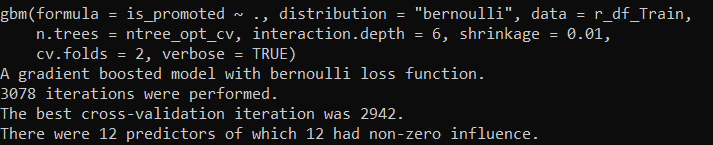

In [20]:
#Predict using the model trained
r(' y_pred <- predict(object=model_gbm,newdata=r_df_Test, n.trees=model_gbm$n.trees,type="response")')

0.009694,0.069960,0.052991,0.028241,...,0.003614,0.148164,0.003019,0.003922


In [21]:
#Save the y_pred R FloatVector into python environment
y_pred=r['y_pred']
y_pred

0.009694,0.069960,0.052991,0.028241,...,0.003614,0.148164,0.003019,0.003922


After saved into python environment, the y_pred type is still FloatVector, so we need to convert into python list for the further action.

In [22]:
#Convert FloatVector into python list
y_pred=np.asarray(y_pred).tolist()

In [23]:
#Labeling the y_pred into binary variable
y_pred=list(map(lambda x: 1 if x>0.5 else 0,y_pred))

In [24]:
#Check the F1 Score and confusion matrix
print('F1 Score: ',f1_score(y_Test, y_pred, average='binary'))
print('')
tn, fp, fn, tp = confusion_matrix(y_Test,y_pred).ravel()
print('True Negative: ',tn,' False Positive: ',fp,' False Negative: ',fn,' True Positive: ',tp)
print('')
print(confusion_matrix(y_Test,y_pred))

F1 Score:  0.48312236286919835

True Negative:  15005  False Positive:  37  False Negative:  943  True Positive:  458

[[15005    37]
 [  943   458]]


By using without generate any new features nor do the hyperparameter tuning, we got around 0.48 F1-Score by using GBM from R package!